# Korpuserstellung mit Hilfe von Genreklassifikation

Unter Textklassifizierung versteht man den Prozess der Einteilung von Text in vordefinierte Gruppen. Durch den Einsatz von Natural Language Processing (NLP) Methoden können Textklassifizierer den Text automatisch analysieren und dann eine Reihe vorgegebener Kategorien zuweisen. Diese automatische Klassifizierung von Text in vordefinierte Kategorien ist eine wichtige Methode zur Verwaltung und Verarbeitung einer großen Anzahl von Zeitungsausschnitten. Dies gilt auch für Subkorpora zu einem bestimmten Forschungsthema (z.B. Migration). Das Ziel dieses Notebooks ist es, ein Modell mit Ihrem zuvor manuell erstellten Trainings-/Testkorpus zu trainieren und dieses Modell zu verwenden, um einen Überblick über die Kategorienverteilung in Ihrer Sammlung zu erhalten (siehe Abbildung unten). Ein weiteres Ziel ist es, Ihre kategorisierten Daten für weitere Analysen zu exportieren. So können Sie z. B. die Werbung zu einem bestimmten Thema untersuchen.

Dieses Notebook klassifiziert Zeitungsartikel zum Thema "Auswanderng" in deutschsprachigen Zeitungen zwischen 1850 und 1950. Für den Trainings- und Testkorpus wurde eine Sammlung mit den Stichwörtern "Auswander*", "Ausgewanderte", "Emigrant*", "Emigrierte", "Auswanderung", "Kolonist*" und "Ansiedler*" erstellt. Dieser Trainingskorpus wurde manuell annotiert. 

Als Basis für die Klassifizierung dient ein Topic Modeling Modell. LDA bietet eine Möglichkeit, Dokumente nach Themen zu gruppieren, Ähnlichkeitssuchen durchzuführen und die Genauigkeit zu verbessern. Dank sklearn ist es relativ einfach, verschiedene Klassifikatoren für eine bestimmte thematische Klassifikationsaufgabe zu testen. Als binärer Klassifikator wurde die logistische Regression gewählt. 

*Die folgende Grafik zeigt die Verteilung der vordefinierten Kategorien in Zeitungsausschnitten ausgewählter österreichischer Zeitungen (Stichprobe von 10854 Zeitungsausschnitten) zum Thema Auswanderung. 

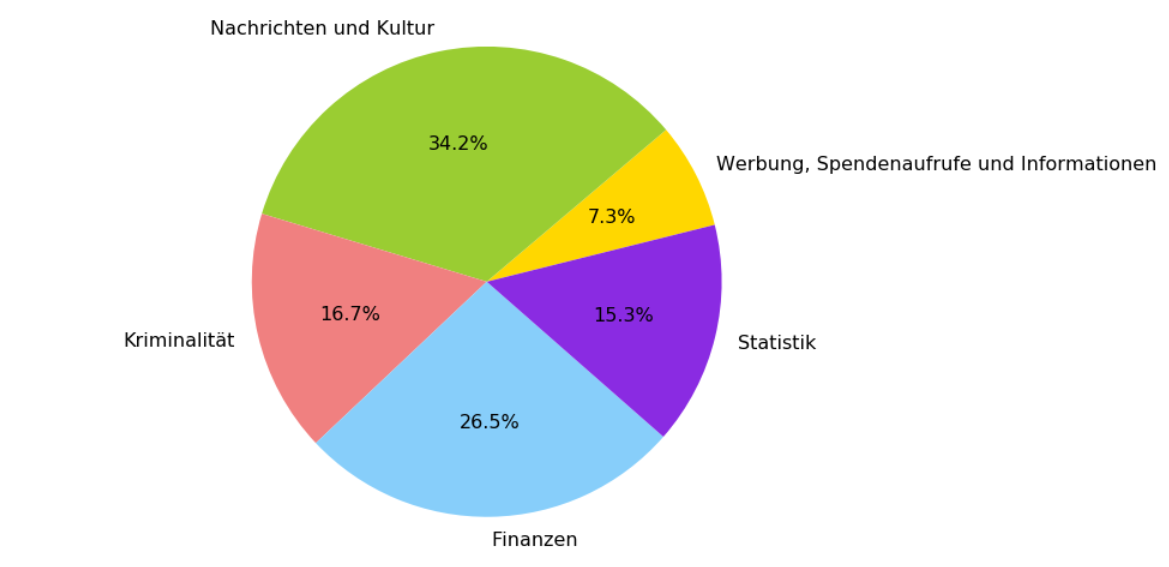

## Schritt für Schritt..
* [Eine manuell annotierte Kollektion erstellen und importieren](#1-bullet)
* [Pre-processing and die Bildung eines Trainings- und testkorpus](#2-bullet)
* [LDA Modell trainieren](#3-bullet)
* [Klassifier anwenden](#4-bullet)
* [Modell am Testkorpus testen](#5-bullet)
* [Anwendung des Klassifiers auf den gesamten Korpus](#6-bullet)
* [Ergebnisse Visualisieren](#7-bullet)


## Eine manuell annotierte Kollektion erstellen und importieren <a class="anchor" id="1-bullet"></a>

Manuelle Annotationen sind wesentlich für die Klassifizierung. Deshalb wird eine Kollektion vorbereitet, die 80 bis 100 Artikeln pro Kategorie umfasst. Um diese Sammlung zu erstellen, wurden den Artikeln die Nummern 0 bis 7 zugewiesen, wobei jede Nummer für eine Zeitungskategorie steht: 


0 = Werbung, Spendenaufrufe und Informationen
 
1 = Nachrichten und Kultur

4 = Kriminalität

6 = Finanzen

7 = Statistik

Wenn Sie Ihre eigene Sammlung erstellen, achten Sie darauf, dass Sie eine repräsentative Sammlung für das gesamte Suchergebnis erstellen. Wenn Sie einen langen Zeitraum verwenden, stellen Sie sicher, dass alle Zeitabschnitte in Ihrer kleinen Sammlung vertreten sind. 

In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import sys
import time
pd.set_option('mode.chained_assignment', None)

df = pd.read_csv('export_classification_emigration_new_06_07_2020_23_15 - Copy.csv')

print(df.shape)
df.head(3)

(698, 7)


,id,language,date,newspaper_id,iiif_url,relevancy,text
0,illustrierte_kronen_zeitung_krz19110626_articl...,de,1911-06-26T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"Blumenjunge, Meidling. Sie erhalten jetzt\nim ..."
1,illustrierte_kronen_zeitung_krz19110403_articl...,de,1911-04-03T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"Wien—Amerika, Zentagasse. Vor der Auswanderung..."
2,illustrierte_kronen_zeitung_krz19111027_articl...,de,1911-10-27T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"Auskünfte.\n Kolonie 1000, Viktor\nM. Wenden S..."


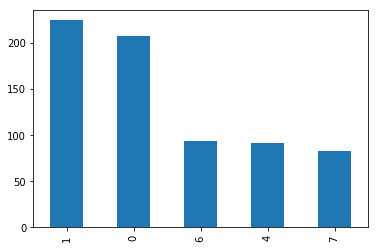

In [2]:
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
import matplotlib.pyplot as plt
df.relevancy.value_counts().plot(kind='bar')

## Pre-processing and die Bildung eines Trainings- und testkorpus) <a class="anchor" id="2-bullet"></a>

##### Reinigen, tokenisieren und stemmen

Bevor Textmining Methoden angewendet werden können, muss der Text bereinigt(Interpunktion wird entfernt, alle Wörter werden kleingeschrieben), und tokenisiert (der Text wird in einzelne sprachliche Einheiten zerlegt) werden. Außerdem werden Stoppwörter entfernt und die Token gestemmt (flektierte Wörter auf ihren Wortstamm reduziert). Das Pre-Processing ist wichtig, da Interpunktion oder Sonderzeichen für die weitere Analyse in der Regel nicht benötigt werden. Das Gleiche gilt für Wörter wie *und*, *oder*, *mit* und ähnliche, die nicht als wichtiger Kontext betrachtet werden können. Aus diesem Grund werden wir im nächsten Schritt nur jene Wörter beibehalten, die eine Unterschiedung von relevanten und nicht-relevanten Kontexten ermöglichen.

Ein weiterer Pre-Processing Schritt, der angewendet werden könnte, ist die Lemmatisierung (Umwandlung von Wörtern in ihre Lemmaform/Lexeme). In diesem Notebook wird jedoch ein deutschsprachigen Stemmer verwendet, da dieser weniger Verarbeitungsaufwand erfordert (kein Part-of-Speech-Tagging erforderlich). Wir haben jedoch die Liste der deutschen Stoppwörter aus dem NLTK-Paket erweitert. Eine längere Liste mit deutschen Stoppwörtern wurde von https://countwordsfree.com/stopwords/german abgerufen und der bestehenden Datei hinzugefügt.

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import spacy

# Functions to clean, tokenize, and lemmatize the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

nltk.download('stopwords')
nltk.download('punkt')

stop_words = stopwords.words('german')#change the language here
# add your onw stop words
stop_words.extend(['auswanderer', 'auswanderung', 'auswanderern'])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = SnowballStemmer("german")
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

df['tokenized'] = df['text'].apply(apply_all) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c62255\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c62255\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In einem weiteren Schritt wird die Sammlung in ein Trainings- und Testkorpus zu unterteilt. Damit erhalten wir eine Reihe von Dokumenten (Trainingskorpus), um den Algorithmus zu trainieren, und eine Reihe von Dokumenten (Testkorpus), um die Effizienz der gewählten Methoden zu testen.

##### Training- und Testkorpus

Um die Sammlung in ein Trainings- und ein Testkorpus aufzuteilen, wird die Funktion numpy.random.rand() verwendet, um ein Array mit einer bestimmten Form zu erstellen und es mit Zufallswerten zu füllen. Dies ermöglichte es, eine gute Mischung aus relevanten und nicht relevanten Artikeln in jedem der Korpora zu erhalten (Abbildung 2). Da diese Funktion auf dem Zufallsprinzip beruht und die Aufteilung der Korpora bei jedem Aufruf variieren kann, wurde ein Zufallswert gesetzt, um reproduzierbare Aufrufe zu erzeugen. Folglich sind alle Zufallszahlen, die nach dem Setzen des Seeds erzeugt werden, auf jeder Maschine gleich.

In [4]:
# create a mask of binary values
#7979
#7989
np.random.seed(9989)
msk = np.random.rand(len(df)) < 0.850

In [5]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [6]:
print(len(df),len(train_df),len(test_df))

698 599 99


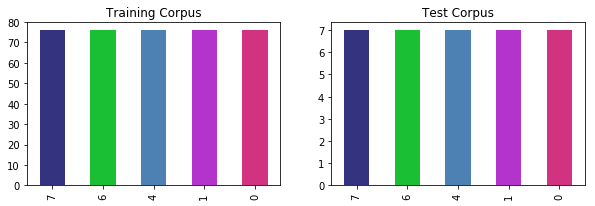

In [7]:
val = train_df.relevancy.value_counts().min()
train_df = train_df.groupby('relevancy').head(val)
val_2 = test_df.relevancy.value_counts().min()
test_df = test_df.groupby('relevancy').head(val_2)
#plot the result
my_colors = [(0.20,0.200,0.50), (0.100, 0.75, 0.200),(0.30,0.500,0.70), (0.70,0.20,0.80), (0.82,0.200,0.50), (0.20,0.200,0.50)] #set colors
fig, axes = plt.subplots(1,2,figsize=(10,3))
test_df.relevancy.value_counts().plot(kind='bar', color = (0.100, 0.75, 0.20), ax=axes[1])
test_df.relevancy.value_counts().plot(kind='bar', color = my_colors, ax=axes[1])
train_df.relevancy.value_counts().plot(kind='bar', color = (0.100, 0.75, 0.20), ax=axes[0])
train_df.relevancy.value_counts().plot(kind='bar', color = my_colors, ax=axes[0])
axes[1].title.set_text('Test Corpus')
axes[0].title.set_text('Training Corpus')


## LDA Modell trainieren <a class="anchor" id="3-bullet"></a>

Topic Modelle beruhen auf der Annahme, dass Texten in natürlicher Sprache eine relativ kleine Menge latenter oder verborgener Themen zugrunde liegt, wobei ein Wort zu mehreren Themen gehören kann. Themenmodelle verwenden die so genannte Bag-of-Words-Annahme innerhalb eines Dokuments bzw. sie gruppieren statistisch signifikante Wörter innerhalb eines bestimmten Korpus. Wie von (Blei, Ng und Jordan 2003) beschrieben, können Dokumente "als zufällige Mischungen über latente Themen dargestellt werden, wobei jedes Thema durch eine Verteilung über Wörter charakterisiert ist". Die Themenmodellierung wird für verschiedene Zwecke eingesetzt: um einen Koprpus besser zu verstehen (Zosa et al. 2020), um Diskursdynamik zu erfassen (Marjanen et al. 2020), um einen besseren Einblick in die Art oder das Genre von Dokumenten in einem Korpus zu erhalten (Oberbichler 2021), um die Entwicklung von Themen und Trends in mehrsprachigen Sammlungen zu erfassen (Zosa und Granroth-Wilding 2019) oder um verschiedene Korpora zu vergleichen (Lu, Henchion und Namee 2019).

Jeder dieser Anwendungsbereiche benötigt unterschiedliche Parameter. Während Methoden zur automatischen Bestimmung der Themenanzahl in einigen Fällen hilfreich sein können (Zhao et al. 2015) (O'Callaghan et al. 2015), ist das genaue Lesen einer beträchtlichen Menge von Dokumenten nach wie vor am zuverlässigsten.

Wir verwenden hier die Python-Library Gensim, um die Topic Modelle zu trainieren. Gensim ist eine Bibliothek, die für die Themenmodellierung, die Dokumentenindexierung als auch die Ähnlichkeitssuche verwendet wird. Alle Algorithmen sind speicher- und sprachunabhängig sowie unüberwacht, was bedeutet, dass keine menschliche Eingabe erforderlich ist.

In [8]:
import gensim
from gensim.corpora import Dictionary
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from gensim.models import LdaModel

dictionary = corpora.Dictionary(train_df['tokenized'])

#Make a BOW for every document (Bag of words)
def document_to_bow(df):
    train_df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), train_df['tokenized']))
    
document_to_bow(train_df)

corpus = train_df.bow

def train_lda(data):
    num_topics = 500
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                    minimum_probability=0.0, passes=50, iterations=500, per_word_topics=True)
    return dictionary,corpus,lda

dictionary,corpus,lda = train_lda(train_df)

lda.show_topic(topicid=0, topn=20)

C:\Users\c62255\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[('vermog', 0.038262255),
 ('ausland', 0.026925985),
 ('steh', 0.025516603),
 ('vorschrift', 0.025514081),
 ('freiheit', 0.025512561),
 ('viertel', 0.0215812),
 ('verfug', 0.015846413),
 ('neu', 0.013474374),
 ('deutsch', 0.013271546),
 ('erfahr', 0.012770946),
 ('streng', 0.012770918),
 ('wert', 0.012770913),
 ('erich', 0.012770913),
 ('grosstmog', 0.012770913),
 ('hemmt', 0.012770913),
 ('hemmungslos', 0.012770913),
 ('kapitalsflucht', 0.012770913),
 ('hinsicht', 0.012770913),
 ('bank', 0.012770913),
 ('lungwitz', 0.012770913)]

## Klassifier anwenden <a class="anchor" id="4-bullet"></a>

##### Numerische Darstellung der Topicverteilungen

Viele Algorithmen im Bereich des maschinellen Lernens erfordern eine numerische Darstellung von Objekten, da solche Darstellungen die Verarbeitung und statistische Analyse erleichtern.

In [9]:
def document_to_lda_features(lda, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train_df['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(lda, doc),
                                      train_df.bow))

In [10]:
ads_topic_distribution = train_df.loc[train_df.relevancy == 0, 'lda_features'].mean()
news_topic_distribution = train_df.loc[train_df.relevancy == 1, 'lda_features'].mean()
crime_topic_distribution = train_df.loc[train_df.relevancy == 4, 'lda_features'].mean()
finances_topic_distribution = train_df.loc[train_df.relevancy == 6, 'lda_features'].mean()
statistic_topic_distribution = train_df.loc[train_df.relevancy == 7, 'lda_features'].mean()
print('Auszug aus der Kategorie: Werbung, Spendenaufrufe und Informationen')
print(ads_topic_distribution[0:15])

Auszug aus der Kategorie: Werbung, Spendenaufrufe und Informationen
[0.0002008  0.0002008  0.00149593 0.0002008  0.0002008  0.0002008
 0.0002008  0.0002008  0.00506548 0.0002008  0.0002008  0.0002008
 0.0002008  0.0002008  0.01301242]


##### Wörter, die die die einzelnen Kategorien repräsentieren

In [11]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words
for relevancy, distribution in zip(['Werbung, Spendenaufrufe und Informationen', 'Nachrichten und Kultur', 'Kriminalität', 'Finanzen', 'Statistik'], [ads_topic_distribution, news_topic_distribution, crime_topic_distribution, finances_topic_distribution, statistic_topic_distribution]):
    print("Top Wörter dominater Topics für die Kategorie: {}".format(relevancy))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(lda, x)
        print("Für das Topic {}, lauten die Top Wörter: {}.".format(x, ", ".join(top_words)))
    print("")

Top Wörter dominater Topics für die Kategorie: Werbung, Spendenaufrufe und Informationen
Für das Topic 47, lauten die Top Wörter: auskunftskal, teil, briefmark, zugeschickt, portofrei.
Für das Topic 191, lauten die Top Wörter: weg, verkauf, nah, brief, billig.
Für das Topic 226, lauten die Top Wörter: arm, word, ruman, spend, morgenblatt.
Für das Topic 431, lauten die Top Wörter: einsend, auskunftsstell, les, erhalt, pass.
Für das Topic 451, lauten die Top Wörter: bez, beim, wien, erhalt, neu.

Top Wörter dominater Topics für die Kategorie: Nachrichten und Kultur
Für das Topic 84, lauten die Top Wörter: dr, frank, gustav, edmund, uhr.
Für das Topic 238, lauten die Top Wörter: word, paris, brot, mehr, imm.
Für das Topic 420, lauten die Top Wörter: klass, erst, geht, soldat, angenehm.
Für das Topic 463, lauten die Top Wörter: armen, grenz, eriwan, turkei, zuruckkehr.
Für das Topic 469, lauten die Top Wörter: fahrt, newyork, italien, versenkt, osterreichischungar.

Top Wörter dominater To

##### Klassifier Modell  trainieren 
Nachdem die Dokumente in Daten umgewandelt wurden, ist es wichtig, einige kontrollierte Klassifikatoren anzuwenden, um vorhersagen zu können, welcher Text zu welcher Kategorie gehört.

In [12]:
from gensim.models.ldamulticore import LdaMulticore
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

def get_cross_validated_model(model, param_grid, X, y, nr_folds=6):
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, train_df.lda_features)))


## Modell am Testkorpus testen  <a class="anchor" id="5-bullet"></a>

In [13]:
test_df.head()

,id,language,date,newspaper_id,iiif_url,relevancy,text,tokenized
0,illustrierte_kronen_zeitung_krz19110826_articl...,de,1911-08-26T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"Laura, Siemensstraße.\nSie können die Auswande...","[laura, siemensstrass, auswanderungsbewill, er..."
1,illustrierte_kronen_zeitung_krz19130623_articl...,de,1913-06-23T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"Amerika, Volkertplatz. Lesen Sie den ausführli...","[amerika, volkertplatz, les, ausfuhr, artikel,..."
2,illustrierte_kronen_zeitung_krz19120214_articl...,de,1912-02-14T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"Zmsktünftr.\nEifriger Leser, Leopoldauerplatz,...","[zmsktunftr, eifrig, les, leopoldauerplatz, be..."
3,illustrierte_kronen_zeitung_krz19130305_articl...,de,1913-03-05T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"J. F., Heumühlgasse.\nPesen Sie die Artikel\n...","[heumuhlgass, pes, artikel, amerikareis, ausku..."
4,arbeiter_zeitung_aze19130403_article_268,de,1913-04-03T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,6,Volkswirtschaft.\nSchutz der Auswanderer oder ...,"[volkswirtschaft, schutz, vermehr, lohndruck, ..."


#### Pre-processing

In [14]:
test_df['tokenized'] = test_df['text'].apply(apply_all) 
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), test_df['tokenized']))
    
document_to_bow(test_df)

test_df['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(lda, doc),
                                     test_df.bow))
X_test_lda = np.array(list(map(np.array, test_df.lda_features)))
# store all models in a dictionary
models = dict()

##### Logistic Regression 
Die logistische Regression ist ein Klassifizierungsalgorithmus des maschinellen Lernens, der zur Vorhersage der Wahrscheinlichkeit einer kategorialen abhängigen Variablen verwendet wird. 


In [15]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()

param_grid = {'penalty': ['l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, train_df.relevancy)

models['best_lr_lda'] = best_lr_lda

Fitting 6 folds for each of 1 candidates, totalling 6 fits


,mean_test_score,rank_test_score,param_penalty
0,-1.391227,1,l2


###### Klassifizierung
Zunächst erhalten wir einen Datenrahmen mit dem Ergebnis für jede Kategorie. Die Kategorie mit der höchsten Zahl ist die Kategorie, der der Artikel zugeordnet ist. 

In [16]:
submission_predictions = best_lr_lda.predict_proba(X_test_lda)
result= np.append(test_df.relevancy.values.reshape(-1,1), submission_predictions, axis=1)
submission_df = pd.DataFrame(data=result, columns=['relevancy', 'ads', 'news', 'crime', 'finance', 'statistic'])
submission_df.head(5)

,relevancy,ads,news,crime,finance,statistic
0,0.0,0.464399,0.118817,0.125793,0.127426,0.163564
1,0.0,0.738837,0.068195,0.063235,0.067770,0.061962
2,0.0,0.398735,0.164213,0.152385,0.145075,0.139592
3,0.0,0.419051,0.138569,0.142370,0.134363,0.165647
4,6.0,0.161607,0.228238,0.190157,0.234340,0.185658


In [17]:
max_num = submission_df.loc[:, submission_df.columns != 'relevancy'].max(axis=1)

df_ads = submission_df[['ads', 'relevancy']][submission_df['ads'].isin(max_num)]

ads_list = []
for key, value in df_ads.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            ads_list.append(rel)

ads_right = []
ads_wrong =[]
for num in ads_list: 
    if num == 0.0: 
        ads_right.append(num)
    else: 
        ads_wrong.append(num)
all_ = len(ads_right) + len(ads_wrong)
ads_score = len(ads_right) / all_
print(f"Your score for ads is: {ads_score}")

df_news = submission_df[['news', 'relevancy']][submission_df['news'].isin(max_num)]


news_list = []
for key, value in df_news.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            news_list.append(rel)

news_right = []
news_wrong =[]
for num in news_list: 
    if num == 1.0: 
        news_right.append(num)
    else: 
        news_wrong.append(num)
all_ = len(news_right) + len(news_wrong)
news_score = len(news_right) / all_
print(f"Your score for news is: {news_score}")

df_crime = submission_df[['crime', 'relevancy']][submission_df['crime'].isin(max_num)]

crime_list = []
for key, value in df_crime.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            crime_list.append(rel)

crime_right = []
crime_wrong =[]
for num in crime_list: 
    if num == 4.0: 
        crime_right.append(num)
    else: 
        crime_wrong.append(num)
all_ = len(crime_right) + len(crime_wrong)
crime_score = len(crime_right) / all_
print(f"Your score for crime is: {crime_score}")


df_finances = submission_df[['finance', 'relevancy']][submission_df['finance'].isin(max_num)]

finances_list = []
for key, value in df_finances.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            finances_list.append(rel)

finances_right = []
finances_wrong =[]
for num in finances_list: 
    if num == 6.0: 
        finances_right.append(num)
    else: 
        finances_wrong.append(num)
all_ = len(finances_right) + len(finances_wrong)
finance_score = len(finances_right) / all_
print(f"Your score for finances is: {finance_score}")
   
df_statistic = submission_df[['statistic', 'relevancy']][submission_df['statistic'].isin(max_num)]

statistic_list = []
for key, value in df_statistic.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            statistic_list.append(rel)

statistic_right = []
statistic_wrong =[]
for num in statistic_list: 
    if num == 7.0: 
        statistic_right.append(num)
    else: 
        statistic_wrong.append(num)
all_ = len(statistic_right) + len(statistic_wrong)
statistic_score = len(statistic_right) / all_
print(f"Your score for statistic is: {statistic_score}")
overall_score = (ads_score + news_score  + crime_score + finance_score + statistic_score) / 5

print(f"Your overall score is {overall_score}")

Your score for ads is: 1.0
Your score for news is: 0.8
Your score for crime is: 1.0
Your score for finances is: 0.75
Your score for statistic is: 0.6666666666666666
Your overall score is 0.8433333333333334


## Anwendung des Klassifiers auf den gesamten Korpus  <a class="anchor" id="6-bullet"></a>


In [18]:
df_all = pd.read_csv('export_auswander_01_04_2021_23_08.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])
df_all_2 = pd.read_csv('export_auswander_01_04_2021_23_08.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])
df_all['tokenized'] = df_all['text'].apply(apply_all)

##### Anzahl der Wörter und Texte im der Sammlung

In [19]:
from nltk import FreqDist
# first get a list of all words
all_words = [word for item in list(df_all['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"The number of unique words is {len(fdist)}"

'The number of unique words is 89007'

In [20]:
#document length
df_all['doc_len'] = df_all['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df_all['doc_len'])
df_all.drop(labels='doc_len', axis=1, inplace=True)


print(f"length of list: {len(doc_lengths)}")
print(f"average document length: {np.average(doc_lengths)}")
print(f"minimum document length: {min(doc_lengths)}")
print(f"maximum document length: {max(doc_lengths)}")

length of list: 11733
average document length: 65.67152475922612
minimum document length: 0
maximum document length: 610


##### Sehr kurze Artikel (unter 7 Token) werden ausgeschlossen

In [21]:
df_all = df_all[df_all['tokenized'].map(len) >= 7]
df_all = df_all[df_all['tokenized'].map(type) == list]
df_all.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_all), "articles")

df_all_2 = df_all[df_all['tokenized'].map(len) >= 7]
df_all_2 = df_all[df_all['tokenized'].map(type) == list]
df_all_2.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_all), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10854 articles
After cleaning and excluding short aticles, the dataframe now has: 10854 articles


#### Klassifikation

In [22]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df_all['tokenized']))
    
document_to_bow(df_all)
df_all['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(lda, doc),
                                     df_all.bow))
X_all_lda = np.array(list(map(np.array, df_all.lda_features)))
submission_predictions = best_lr_lda.predict_proba(X_all_lda)
result= np.append(df_all.text.values.reshape(-1,1), submission_predictions, axis=1)
result_2= np.append(df_all_2, submission_predictions, axis=1)
submission_df_all = pd.DataFrame(data=result, columns=['text', 'werbung, spendenaufrufe und informationen', 'nachrichten und kultur', 'kriminalität', 'finanzen', 'statistik'])
submission_df_all_2 = pd.DataFrame(data=result_2, columns=['id','language','date','newspaper_id','iiif_url','text', 'token', 'ads', 'news', 'crime', 'finance', 'statistic'])
submission_df_all.head(5)

,text,"werbung, spendenaufrufe und informationen",nachrichten und kultur,kriminalität,finanzen,statistik
0,"Künstlerdrame Füep## ea#r##ede siegt“,\nKunstt...",0.149518,0.254327,0.177208,0.173051,0.245897
1,"Industrie=Schulung\nf Auswanderer. Dr. techn.,...",0.174445,0.324165,0.173375,0.179082,0.148933
2,ternationales Transporlweser\nAbtellung: Auswa...,0.175168,0.210881,0.20662,0.214154,0.193178
3,VI. Stumnergasse 19/21\nDreimonatige Auswander...,0.190883,0.205755,0.231474,0.174815,0.197073
4,jeder andere staubgeborene Professor und Geleh...,0.202995,0.244782,0.176997,0.20099,0.174237


In [23]:
max_num = submission_df_all.loc[:, submission_df_all.columns != 'text'].max(axis=1)

In [24]:
ads = submission_df_all[['text']][submission_df_all['werbung, spendenaufrufe und informationen'].isin(max_num)]
news = submission_df_all[['text']][submission_df_all['nachrichten und kultur'].isin(max_num)]
crime = submission_df_all[['text']][submission_df_all['kriminalität'].isin(max_num)]
finance = submission_df_all[['text']][submission_df_all['finanzen'].isin(max_num)]
statistic = submission_df_all[['text']][submission_df_all['statistik'].isin(max_num)]

In [25]:
#transform your lists into a dataframe

df_ads = pd.DataFrame(np.column_stack([ads]), 
                               columns=['Werbung, Spendenaufrufe und Informationen'])


df_news = pd.DataFrame(np.column_stack([news]), 
                               columns=['Nachrichten und Kultur'])

df_crime = pd.DataFrame(np.column_stack([crime]), 
                               columns=['Kriminalität'])



df_finance = pd.DataFrame(np.column_stack([finance]), 
                               columns=['Finanzen'])

df_statistic = pd.DataFrame(np.column_stack([statistic]), 
                               columns=['Statistik'])

df_results = pd.concat([df_ads, df_news,df_crime, df_finance, df_statistic], ignore_index=True, axis=1)
df_results.columns=['Werbung, Spendenaufrufe und Informationen','Nachrichten und Kultur','Kriminalität', 'Finanzen', 'Statistik']
df_results['Werbung, Spendenaufrufe und Informationen'][40:45] = df_results['Werbung, Spendenaufrufe und Informationen'][40:45].apply(lambda x: x[:200])
df_results['Nachrichten und Kultur'][40:45] = df_results['Nachrichten und Kultur'][40:45].apply(lambda x: x[:200])
df_results['Kriminalität'][40:45] = df_results['Kriminalität'][40:45].apply(lambda x: x[:300])
df_results['Finanzen'][40:45] = df_results['Finanzen'][40:45].apply(lambda x: x[:500])
df_results['Statistik'][40:45] = df_results['Statistik'][40:45].apply(lambda x: x[:200])
display(df_results[40:45].style.hide_index())


"Werbung, Spendenaufrufe und Informationen",Nachrichten und Kultur,Kriminalität,Finanzen,Statistik
"Auswanderer nach Amerika, welche sich im Staate Missouri, Bisconsin, in Nordamerika niederlassen, können sowol auf Credit, als auch gegen geringe Zahlung sich Land zum Anbau erwerben. Nebst Ackerbauer","Straßburg, 18. December. [Orig.=Corr.] (Eine Stimme aus Frankreich über Elsaß=Lothringen. Neue Vereine.) Im neuesten Hefte der Revue des deux Mondes veröffentlicht Herr Mézières einen langen Aufsatz,","Lemberg, 15. April. Dem Dilo zufolge hat die Statthalterei zur Eindämmung der Auswanderungs=Bewegung an die griechisch=katholischen Ordinariate in Galizien einen Erlaß gerichtet, wonach die Pfarrämter angewiesen werden sollen, den auswanderungslustigen Bauern Matrikenauszüge, deren sich die selben i","[„Schubertbund“.] In der letzten Versammlung des Vereines „Schubertbund“ machte der Vorstand in Betreff der vom Bunde ausgeschriebenen Preise die Mittheilung, daß die Preisrichter von den zahlreich eingelaufenen Nummern zwei Chöre für den zweiten Preis (5 Ducaten) in Vorschlag brachten. Zur Erlangung des ersten Preises (10 Ducaten) soll ein neuer Concurs ausgeschrieben werden. In der nächsten Versammlung erfolgt die feierliche Zuerkennung der Preise durch den Vorstand. Die in Aussicht genommenen","(Auswanderer.) Aus Triest wird berichtet: Die italienische Emigration nach Amerika nimmt in auße ordentlicher Weise zu. In den drei Monaten August bis October wanderten 71.612 Personen aus, die meiste"
"nachweislich bei einem Werthe von 45,000 fl. mit 10 Perc. rentirend, wird wegen Auswanderung des Besitzers um 10.000 fl. verkauft. Anzahlung 6000 fl. Bewerber belieben ihre Adresse unter D. 3079 der A","Dieselben Blätter übersetzten aus dem Londoner Jewish Chronicle den Brief eines englischen Obersten Hart, in welchem der Schreiber sich auf einen Ausspruch des russischen Consuls in Bukarest bezieht,","Wien, 14. November. [Orig.=Ber.] (Die Noth in Galizien.) Gestern wurden vor einem Erkenntnißsenate unter Vorsitz des Landesgerichtsrathes Granichstädten sechsundzwanzig Verhandlungen gegen achtunddreißig junge Leute aus Galizien durchgeführt, welche vor Erfüllung ihrer Militärpflicht und ohne behörd","det sei. Es wurden Verhandlungen eingeleitet, um den wohnern von Issy und Vanves die Auswanderung zu ermöglichen.",1. Shillings eines Jahres. # F) ver göc kr 1 e.ühung Die Arheitslekon aklon #ei# gio eines Jahr Gesellschaft andel? #ag. Wer zeyn Jahre der — im Rodarfsfalle 8.5 Staur. —nerung 80 kr 3 Ms darf -Von ni
"[Ein Brief an den Papst.] Am Mittwoch Abend fand in Berlin eine Versammlung statt, so wüst, wie man sie, nach der Berliner Börsenzeitung, selten gesehen. Durch die Ankündigung, einen „offenen Brief an","Rumänien., Der amerikanische Koyzmn in Butgrest forderte die rumänische Regierung auf, die Auswanderung der Bukarester Juden nach Amerika zu unterstützen.","Brünn, 22. November. [Orig.=Ber.] (Enthaftung.) Die Inhaber der hiesigen Reisefirma Augusta & Comp., die unter dem Verdachte, militärpflichtigen jungen Männern aus Galizien zur Auswanderung nach Amerika Vorschub geleistet zu haben, am 16. November in Haft genommen waren, wurden heute in Folge Interv","Fast hatte es den Anschein, als wollte die heutige Börse der Flauheit ihren freien Lauf lassen, so geschäftslos und matt war es durch eine lange Zeit auf allen Verkehrsgebieten; da trat auch heute wieder kurz vor dem Börsenschlusse eine kräftige Reprise ein, die der Physiognomie des Marktes ein freundliches, vertrauenerweckendes Gepräge aufdrückte. Die Zinsfußermäßigung der englischen Bank fand nicht die geringste Beachtung; dagegen hatte die Speculation ein neues Moment gefunden, den Verkauf de","woche schifften sich in Genua 5600, in den südlichen Häfen mehr als 4000 italienische Auswanderer ein, welche sich meist nach Brasilien wenden."
"mit der Zeit Zustände herbeiführen muß, wie Großbritannien sie nächstens in Irland beseitigen will. Dem Adelsgeiste widerspricht es, die amerikanisch

## Ergebnisse Visualisieren <a class="anchor" id="7-bullet"></a>


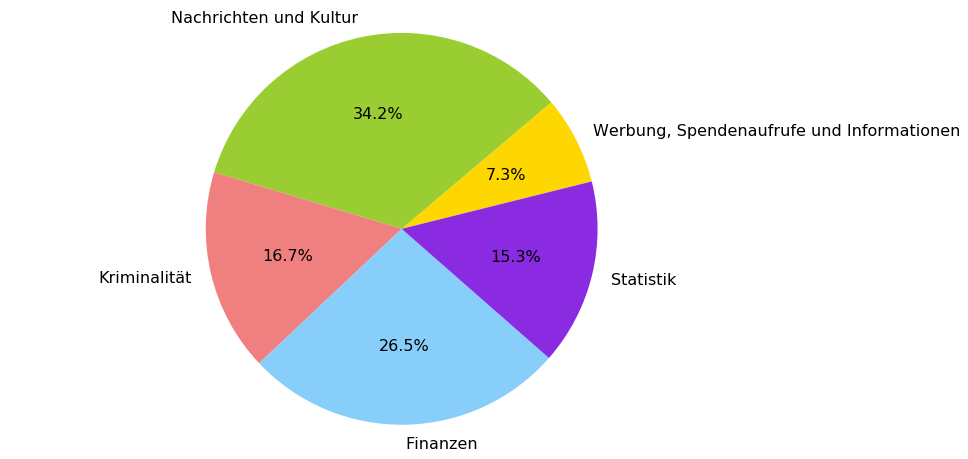

In [26]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(14, 8))
# Data to plot
labels = 'Werbung, Spendenaufrufe und Informationen', 'Nachrichten und Kultur', 'Kriminalität', 'Finanzen', 'Statistik'
sizes = [len(ads), len(news), len(crime), len(finance), len(statistic)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'blueviolet', 'darkturquoise', 'sandybrown', 'pink']
explode = (0, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=14)
plt.axis('equal', fontsize=100)
plt.savefig('circle.png', dpi = 300)

In [27]:
#transform your lists into a dataframe

ads_2 = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['werbung, spendenaufrufe und informationen'].isin(max_num)]
news_2 = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['nachrichten und kultur'].isin(max_num)]
crime_2 = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['kriminalität'].isin(max_num)]
finance_2 = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['finanzen'].isin(max_num)]
statistic_2 = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['statistik'].isin(max_num)]

df_ads = pd.DataFrame(np.column_stack([ads_2]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])


df_news = pd.DataFrame(np.column_stack([news_2]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_crime = pd.DataFrame(np.column_stack([crime_2]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_finance = pd.DataFrame(np.column_stack([finance_2]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_statistic = pd.DataFrame(np.column_stack([statistic_2]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])


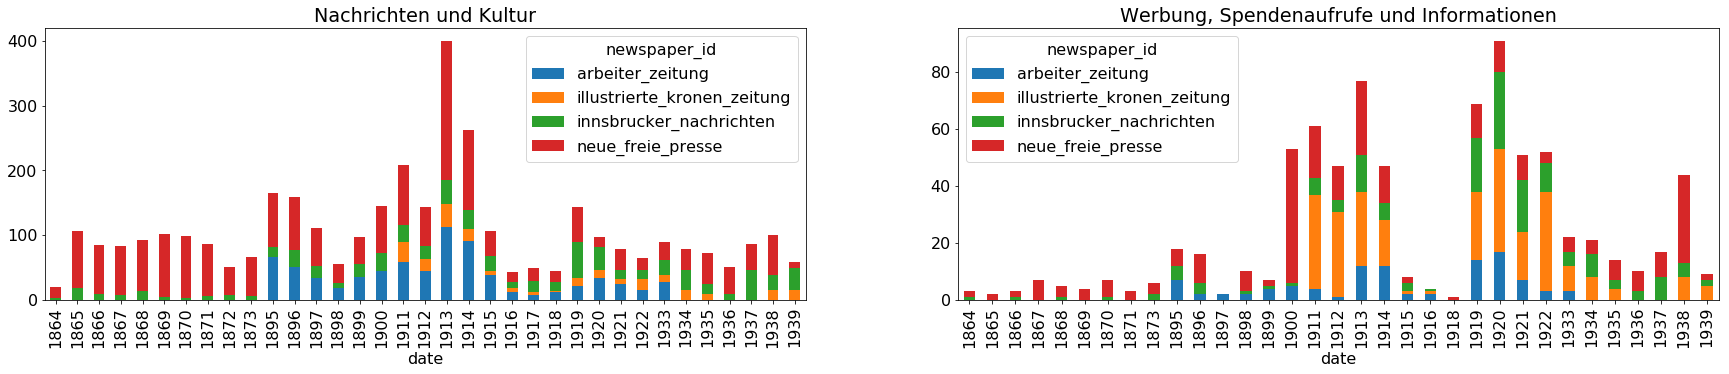

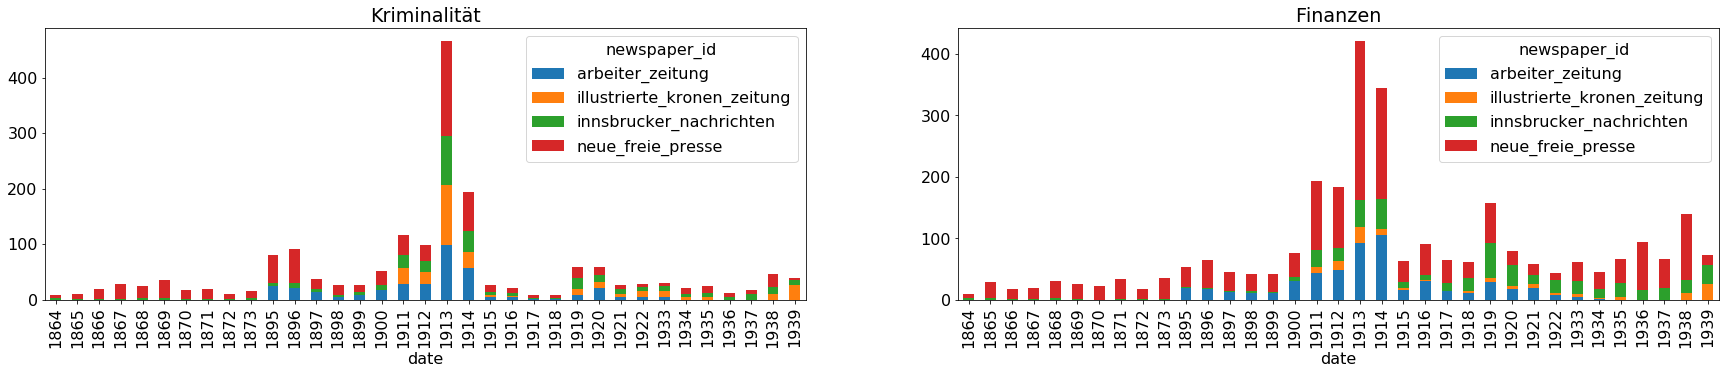

In [28]:
df_ads['date']=pd.to_datetime(df_ads['date']).dt.strftime('%Y')
df_crime['date']=pd.to_datetime(df_crime['date']).dt.strftime('%Y')
df_news['date']=pd.to_datetime(df_news['date']).dt.strftime('%Y')
df_finance['date']=pd.to_datetime(df_finance['date']).dt.strftime('%Y')

fig, axes = plt.subplots(1,2,figsize=(30,5))
df_ads.groupby(['date','newspaper_id']).size().unstack().plot(kind='bar',stacked=True, ax=axes[1])
df_news.groupby(['date','newspaper_id']).size().unstack().plot(kind='bar',stacked=True, ax=axes[0])
axes[1].title.set_text('Werbung, Spendenaufrufe und Informationen')
axes[0].title.set_text('Nachrichten und Kultur')

fig, axes = plt.subplots(1,2,figsize=(30,5))
df_crime.groupby(['date','newspaper_id']).size().unstack().plot(kind='bar',stacked=True, ax=axes[0])
df_finance.groupby(['date','newspaper_id']).size().unstack().plot(kind='bar',stacked=True, ax=axes[1])
axes[0].title.set_text('Kriminalität')
axes[1].title.set_text('Finanzen')